# Cloudy With A Chance of Burst!☁️💥
## Neural Network Classifier

### Import Torch, Pandas, Numpy and utilities from SciKit Learn

In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import nn
import torch
import matplotlib.pyplot as plt

c:\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Choose the best available device.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

Using cpu


### Load the Dataset and Preprocess
Let's load in the dataset, here we are using the ['CloudBurst' dataset](https://www.kaggle.com/datasets/akshat234/cloudburst) by [Akshat_234](https://www.kaggle.com/akshat234), which in turn seems to be derived from the ['Rain in Australia' dataset](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data) by [Joe Young](https://www.kaggle.com/jsphyg) and [Adam Young](https://www.kaggle.com/adamyoung32). 

We remove certain unwanted columns with a lot of nulls, as well as fill the remaining columns' null values with the mean and forward fill for continous and categorical values respectively.

In [3]:
dataset = pd.read_csv('cloudpredictionsystemproject.csv')
dataset = dataset.drop(['Date', 'Evaporation', 'Sunshine', 'CloudBurstTomorrow'], axis=1)

# Filling continous column NAs with mean
numeric_columns = dataset.select_dtypes(include=np.number).columns
dataset[numeric_columns] = dataset[numeric_columns].fillna(round(dataset[numeric_columns].mean(),2))

# Filling categorical column NAs with forward fill
non_numeric_columns = dataset.select_dtypes(exclude=np.number).columns
dataset[non_numeric_columns] = dataset[non_numeric_columns].fillna(method='ffill')

dataset

,Location,MinimumTemperature,MaximumTemperature,Rainfall,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today
0,Albury,13.4,22.90,0.6,W,44.00,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.00,4.51,16.9,21.8,No
1,Albury,7.4,25.10,0.0,WNW,44.00,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.45,4.51,17.2,24.3,No
2,Albury,12.9,25.70,0.0,WSW,46.00,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.45,2.00,21.0,23.2,No
3,Albury,9.2,28.00,0.0,NE,24.00,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.45,4.51,18.1,26.5,No
4,Albury,17.5,32.30,1.0,W,41.00,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.00,8.00,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.40,0.0,E,31.00,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.45,4.51,10.1,22.4,No
145456,Uluru,3.6,25.30,0.0,NNW,22.00,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.45,4.51,10.9,24.5,No
145457,Uluru,5.4,26.90,0.0,N,37.00,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.45,4.51,12.5,26.1,No
145458,Uluru,7.8,27.00,0.0,SE,28.00,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.00,2.00,15.1,26.0,No


### Label Encoding
As a neural network simply cannot operate on categorical data, we must encode all categorical data numerically. Moreover, in consistency with the network's output format, we further define a one hot encoder for the target.

In [4]:
le = LabelEncoder()

for column in dataset.columns:
    if dataset[column].dtype == 'object':
        dataset[column] = le.fit_transform(dataset[column])
dataset

,Location,MinimumTemperature,MaximumTemperature,Rainfall,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today
0,2,13.4,22.90,0.6,13,44.00,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,8.00,4.51,16.9,21.8,0
1,2,7.4,25.10,0.0,14,44.00,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,4.45,4.51,17.2,24.3,0
2,2,12.9,25.70,0.0,15,46.00,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,4.45,2.00,21.0,23.2,0
3,2,9.2,28.00,0.0,4,24.00,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.45,4.51,18.1,26.5,0
4,2,17.5,32.30,1.0,13,41.00,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,7.00,8.00,17.8,29.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,2.8,23.40,0.0,0,31.00,9,1,13.0,11.0,51.0,24.0,1024.6,1020.3,4.45,4.51,10.1,22.4,0
145456,41,3.6,25.30,0.0,6,22.00,9,3,13.0,9.0,56.0,21.0,1023.5,1019.1,4.45,4.51,10.9,24.5,0
145457,41,5.4,26.90,0.0,3,37.00,9,14,9.0,9.0,53.0,24.0,1021.0,1016.8,4.45,4.51,12.5,26.1,0
145458,41,7.8,27.00,0.0,9,28.00,10,3,13.0,7.0,51.0,24.0,1019.4,1016.5,3.00,2.00,15.1,26.0,0


In [5]:
def one_hot(arr):
    return torch.eye(2)[arr]

### Create PyTorch Dataset
We create a module that converts a dataset in CSV format to a PyTorch dataset. Also, in this module, the data of each feature column is standardized, and the target column is one-hot encoded.

We then initialise the train and test data loaders.

In [6]:
class CSV_Dataset(Dataset):
    def __init__ (self, df, train_frac, is_train):
        df = df.to_numpy()
        sc = StandardScaler()
        train_size = int(len(df) * train_frac)
        if(is_train==True):
            x = sc.fit_transform(df[:train_size, :-1])
            y = one_hot(df[:train_size, -1])
            
        else:
            x = sc.fit_transform(df[train_size:, :-1])
            y = one_hot(df[train_size:, -1])
    
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
size = 64
training_data = CSV_Dataset(dataset, 0.7, True)
test_data = CSV_Dataset(dataset, 0.7, False)
train_dataloader = DataLoader(training_data, batch_size=size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=size)

### Define Neural Network
We define a basic feed forward neural network binary classifier with a single hidden layer of height 16. Testing the model on the data has shown that additional hidden layers of any depth yield no significant increase in model accuracy.

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(18, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            # nn.Linear(16, 16),
            # nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)
print(model) 

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)


### Loss Function and Optimizer
We have chosen the Cross Entropy loss function as it is the best suited when it comes to classification problems. For the optimizer, we've opted for the classic Stochastic Gradient Descent optimiser.

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

### Training and testing

In [10]:
def train(dataloader, model, loss, optimizer):
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        inference = model(x)
        loss = loss_function(inference, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  

        # if batch % 100 == 0:
        #     print(f'Batch: {batch}\tLoss: {loss}')

In [11]:
accuracy = []
def test(dataloader, model, loss_function):
    model.eval()
    total_loss , correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            inference = model(x)
            loss = loss_function(inference, y)
            total_loss += loss
            correct += (inference.argmax(1) == y.argmax(1)).type(torch.float).sum()
    total_loss/=len(dataloader)
    correct /= len(dataloader.dataset)
    correct *= 100
    accuracy.append(correct)

    print(f"Average loss: {total_loss} \nAccuracy: {correct}%\n")

In [12]:
epochs = 10

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    print('Training...')
    train(train_dataloader, model, loss_function, optimizer)
    print('Testing...')
    test(test_dataloader, model, loss_function)
print("Training Complete.")

Epoch: 1
Training...


Testing...
Average loss: 0.22275236248970032 
Accuracy: 92.80443572998047%

Epoch: 2
Training...
Testing...
Average loss: 0.0929812341928482 
Accuracy: 97.32343292236328%

Epoch: 3
Training...
Testing...
Average loss: 0.06691347062587738 
Accuracy: 97.9352798461914%

Epoch: 4
Training...
Testing...
Average loss: 0.06299304962158203 
Accuracy: 98.06591033935547%

Epoch: 5
Training...
Testing...
Average loss: 0.06148122251033783 
Accuracy: 97.96507263183594%

Epoch: 6
Training...
Testing...
Average loss: 0.06151925399899483 
Accuracy: 98.13465118408203%

Epoch: 7
Training...
Testing...
Average loss: 0.06370038539171219 
Accuracy: 98.13923645019531%

Epoch: 8
Training...
Testing...
Average loss: 0.062141094356775284 
Accuracy: 98.00173950195312%

Epoch: 9
Training...
Testing...
Average loss: 0.059961240738630295 
Accuracy: 98.0040283203125%

Epoch: 10
Training...
Testing...
Average loss: 0.06237536668777466 
Accuracy: 98.07965850830078%

Training Complete.


### Results
At a modest learning rate of 0.01, the loss converges in 4 epochs, achieving an accuracy of more than 97%

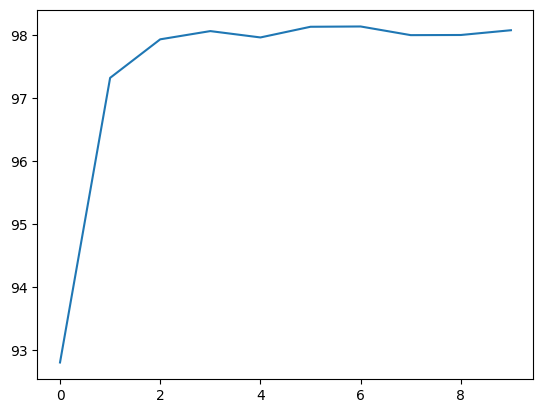

In [13]:
plt.plot(accuracy)

After 4 epochs, the model has achieved:

|Average Loss| Correct Inferences | 
|------------|--------------------|
|0.062|98.080| 